We have previously considered models of the form:

$$ \hat{y} = \beta X + w $$

where we have measured how well the model is doing by minimising the function:

$$ J\left( \beta \right) = \frac{1}{n} \lVert y - \hat{y} \rVert $$

However, this method doesn't allow us to encode some of the ideas we may have about \\(\beta\\).

In least squares regression we are (essentially) solving a series of equations:

$$ y = X \beta $$

but the problem may be ill posed: there may be no \\(\beta\\), or many, which satisfy the above equation. Also, many systems we are interested in moddeling act like low-pass filters going in the direction \\(X \beta\\), so inverting the system naively will act like a high-pass filter and will amplify noise. We can give preference to particular solutions by instead minimising:

$$ J\left( \theta \right) = \frac{1}{n} \lVert y - \hat{y} \rVert_2^2 + \lVert \Gamma \beta \rVert_2^2 $$

Luckily, this equation has a closed form solution:

$$ \hat{\beta} = \left(X^T X + \Gamma^T \Gamma \right)^{-1} X^T y $$

which can be found the same way as the closed form solution for Linear Regression. A particularly important case is \\(\Gamma = \lambda 1\\) (a constant times the identity matrix), which is known by the name of Ridge Regression.

Sometimes we have more complex priors about which solutions we require from any particular optimisation problem, and many cannot be solved by simply taking the gradient. For example

$$ J\left( \theta \right) = \frac{1}{n} \lVert y - \hat{y} \rVert_2^2 + \lVert \beta \rVert_1 $$

this optimisation problem is non differentiable! Or consider

$$ J\left( \theta \right) = \frac{1}{n} \lVert y - \hat{y} \rVert_2^2 + \lVert \nabla \beta \rVert_1 $$

or

$$ J\left( \theta \right) = \frac{1}{n} \lVert y - \hat{y} \rVert_2^2 + \lVert \beta \rVert_0 $$

where

$$ \lVert \beta \rVert_0 = \{\beta \neq 0 \} $$

None of these optimisation problems can be solved in the straightforward way that we solved Ridge regression.

These optimisation problem can be solved by using the following trick, set 

$$ z = \beta $$

in the second term, and then optimise the following function (the last term is to enforce the constraint we introduced):

$$ J\left( \beta \right) = \frac{1}{n} \lVert y - \beta^T X\rVert_2^2 + \lambda \lVert z \rVert_2^2 + \nu^T \left(\beta - z\right) + \frac{\rho}{2} \lVert\beta -z\rVert_2^2 $$

This is cleverer than it looks, because

$$ \frac{\partial J}{\partial \beta} = -X^T \left(y - X\beta\right) + \rho\left(\beta - z\right) + \nu^T $$

and 

$$ \frac{\partial J}{\partial z} = \lambda - \nu^T - \rho\left( \beta - z\right) $$

for \\( z > 0 \\), and 

$$ \frac{\partial J}{\partial z} = - \lambda - \nu^T + \rho\left( \beta - z\right) $$

for \\( z < 0 \\), and 

$$ -\frac{\lambda}{\rho} \leq x + \frac{\nu}{\rho} \leq \frac{\lambda}{\rho} $$

combining these we find:

$$ z = \mathrm{sign}\left(X + \frac{\nu}{\rho}\right) \mathrm{max} \left(\mid X + \frac{\nu}{\rho} \mid - \frac{\lambda}{\rho}, 0 \right) $$

we can then update our weights by the following set of iterates:

$$ X^{k+1} = \left(X^T X + \rho I\right)^{-1} \left(X^t y + \rho \left(z^{k} - \nu^{k}\right)\right)$$

$$ z^{k+1} = S_{\frac{\lambda}{\rho}}\left(X^{k+1} + \nu^{k}/\rho\right) $$

$$ \nu^{k+1} = n^{k} + \rho \left(x^{k+1} - z^{k+1} \right) $$

This is implemented in the code below:

No handles with labels found to put in legend.


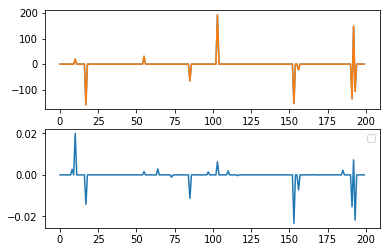

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def l2prox(y, mu):
    return (1.0/(1.0 + mu)) * y

def l1prox(y, mu):
    return np.sign(y)*np.maximum(0, np.absolute(y)-mu/2.0)

def ADMM(A, y, rho, mu, prox):
    """Alternating Direction Method of Multipliers

    This is a python implementation of the Alternating Direction
    Method of Multipliers - a method of constrained optimisation
    that is used widely in statistics (http://stanford.edu/~boyd/admm.html).
    """

    m, n = A.shape
    A_t_A = A.T.dot(A)
    w, v = np.linalg.eig(A_t_A)
    MAX_ITER = 10000

    #Function to caluculate min 1/2(y - Ax) + l||x||
    #via alternating direction methods
    x_hat = np.zeros([n, 1])
    z_hat = np.zeros([n, 1])
    u = np.zeros([n, 1])

    #Calculate regression co-efficient and stepsize
    # r = np.amax(np.absolute(w))
    # l_over_rho = np.sqrt(2*np.log(n)) * r / 2.0 # I might be wrong here
    # rho = mu/r

    #Pre-compute to save some multiplications
    A_t_y = A.T.dot(y)
    Q = A_t_A + rho * np.identity(n)
    Q = np.linalg.inv(Q)
    Q_dot = Q.dot

    for _ in range(MAX_ITER):
        #x minimisation step via posterier OLS
        x_hat = Q_dot(A_t_y + rho*(z_hat - u))
        z_hat = prox(x_hat + u, mu)
        #mulitplier update
        u = u  + rho*(x_hat - z_hat)
    return z_hat

def plot(original, computed):
    """Plot two vectors to compare their values"""
    plt.figure(1)
    plt.subplot(211)
    plt.plot(original, label='Original')
    plt.plot(computed, label='Estimate')
    plt.subplot(212)
    plt.plot(original - computed)
    

    plt.legend(loc='upper right')

    plt.show()

def test(m=50, n=200):
    """Test the ADMM method with randomly generated matrices and vectors"""
    A = np.random.randn(m, n)

    num_non_zeros = 10
    positions = np.random.randint(0, n, num_non_zeros)
    amplitudes = 100*np.random.randn(num_non_zeros, 1)
    x = np.zeros((n, 1))
    x[positions] = amplitudes

    y = A.dot(x) #+ np.random.randn(m, 1)

    plot(x, ADMM(A, y, 1.0, 1.0, l1prox))

test()